In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [176]:
def mean(x, theta):
    a,b = theta
    return a*b*np.exp(-x/b)/x

def mean_curvefit(x, a, b):
    theta = a,b
    return mean(x, theta)

<ErrorbarContainer object of 3 artists>

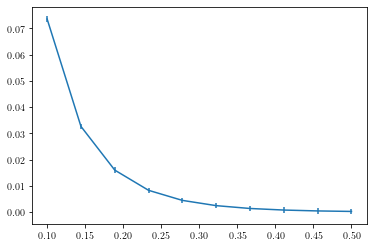

In [177]:
a_true, b_true = 0.2, 0.1
x = np.linspace(0.1,0.5,10)
y_mean = mean(x,[a_true, b_true])
std = .001
plt.errorbar(x, y_mean, std)

In [178]:
y_random = np.random.randn(300, len(x)) 

In [179]:
y_sample = y_random * std + y_mean
cov = np.cov(y_sample.T)

In [180]:
import iminuit
from iminuit import Minuit
def negative_lnL(a, b):
    theta = a, b
    y_th = mean(x, theta)
    inv_cov = np.linalg.inv(cov)
    d = y_sample[0] - y_th
    res = 0.5*np.sum(d*inv_cov.dot(d))
    return res

def lnL_emcee(theta):
    a, b = theta
    return -negative_lnL(a, b)

minuit = Minuit(negative_lnL, a = a_true, b= b_true,
                   errordef = 0.5)
        
minuit.migrad(),minuit.hesse(),minuit.minos()

(┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.145                      │         Nfcn = 40 (40 total)         │
│ EDM = 6.1e-06 (Goal: 0.0001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────

In [181]:
a = minuit.matrix()

In [182]:
a = np.array(a)

In [183]:
a

array([[ 2.84665509e-04, -6.69613637e-05],
       [-6.69613637e-05,  1.60268096e-05]])

In [184]:
import emcee
initial = [a_true,b_true]
npath = 1000
nwalkers = 50
pos = initial + 0.01 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnL_emcee)
print('Single cluster : running...')
sampler_single.run_mcmc(pos, npath, progress=True);

  1%|          | 12/1000 [00:00<00:08, 112.98it/s]

Single cluster : running...


100%|██████████| 1000/1000 [00:08<00:00, 117.77it/s]


Text(0, 0.5, '$c_{200c}$')

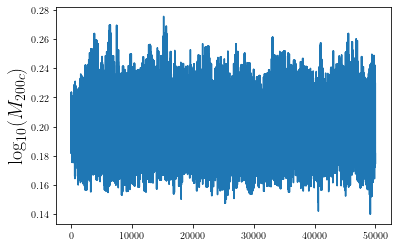

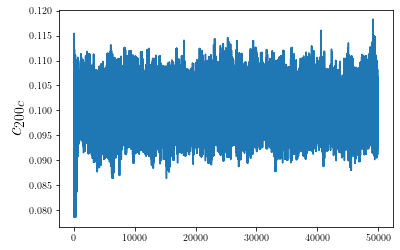

In [185]:
flat_sample_single_pre_cut = sampler_single.get_chain(discard = 0, thin = 1, flat = True)
plt.plot(flat_sample_single_pre_cut[:,0])
plt.ylabel(r'$\log_{10}(M_{200c})$', fontsize= 20)
plt.figure()
plt.plot(flat_sample_single_pre_cut[:,1])
plt.ylabel(r'$c_{200c}$', fontsize= 20)

In [186]:
def Fisher_Matrix(theta, model, x, cov):
    zeros = np.zeros(len(theta))
    delta = 1e-7
    derivative = []
    for i in range(len(theta)):
        delta_i = np.zeros(len(theta))
        delta_i[i] = delta
        derivative.append((model(x, np.array(theta) + delta_i/2) - model(x, np.array(theta) - delta_i/2))/delta)
    Fisher_matrix = np.zeros([len(theta), len(theta)])
    for i in range(len(theta)):
        for j in range(len(theta)):
            Fisher_matrix[i,j] = np.sum(derivative[i]*np.linalg.inv(cov).dot(derivative[j]))
    Fisher_matrix_inv = np.linalg.inv(Fisher_matrix)
    Fisher_matrix_diag_inv = np.linalg.inv(np.diag(Fisher_matrix.diagonal()))
    return Fisher_matrix_inv, Fisher_matrix_diag_inv

In [187]:
MLE = [minuit.values['a'], minuit.values['b']]

In [188]:
Fisher_matrix_inv, Fisher_matrix_diag_inv = Fisher_Matrix(MLE, mean, x, cov)

In [189]:
a

array([[ 2.84665509e-04, -6.69613637e-05],
       [-6.69613637e-05,  1.60268096e-05]])

In [190]:
Fisher_matrix_inv

array([[ 2.86303366e-04, -6.73549505e-05],
       [-6.73549505e-05,  1.61213893e-05]])

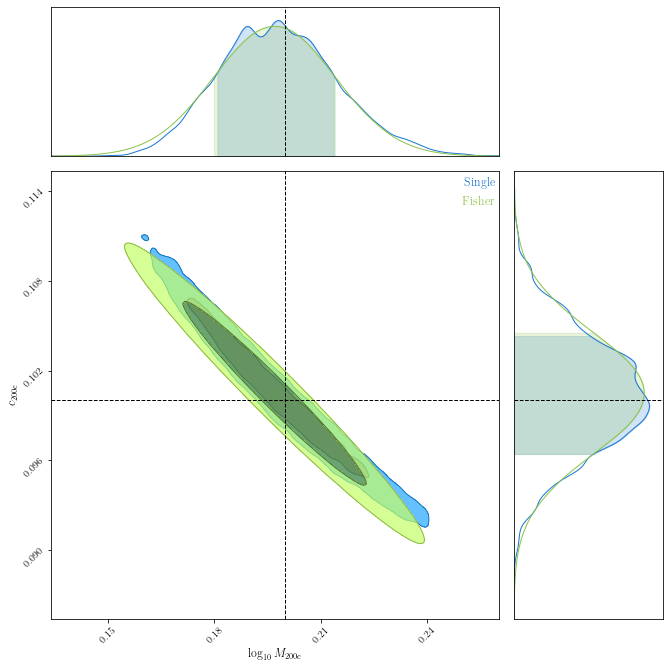

In [192]:
discard, thin = 500, 10
flat_sample_single = sampler_single.get_chain(discard = discard, thin = thin, flat = True)
import numpy as np
from chainconsumer import ChainConsumer
labels = [r'$\log_{10} M_{\rm 200c}$',r'$c_{\rm 200c}$', ]

cs = ChainConsumer()
cs.add_chain(flat_sample_single, parameters=labels, name = 'Single')

cs.add_covariance(MLE, Fisher_matrix_inv, parameters=labels, name="Fisher")

#cs.add_covariance(MLE, a, parameters=labels, name="Minuit")


fig = cs.plotter.plot(figsize="column", truth=[a_true, b_true])
fig.set_size_inches(10, 10)